In [1]:
%matplotlib inline

In [1]:
import numpy as np
import scanpy as sc
import stream2 as st2

# Data
We load example data taken from monocle3 tutorials (https://cole-trapnell-lab.github.io/monocle3/docs/clustering/). 

The adata.X slot is empty as we will simply make use of the PCA and low dimensional representation to illustrate STREAM2 features for complex trajectories

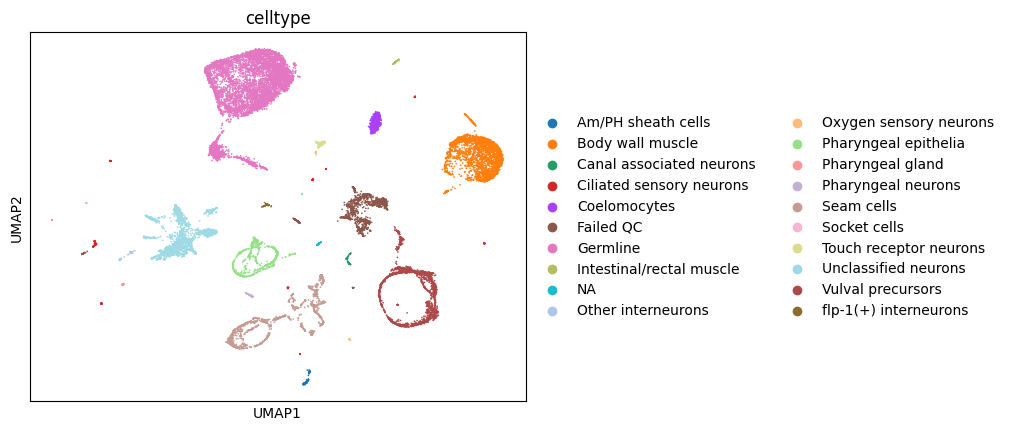

In [2]:
adata = sc.read('../data/monocle/clus_tutorial_monocle.h5ad')
sc.pp.subsample(adata,fraction=.5)
sc.pl.umap(adata,color=['celltype'])

We will first identify disconnected components in the data.

This requires kNN search and a vector of cluster labels. Here we will take leiden clustering labels as input

Found 37 components


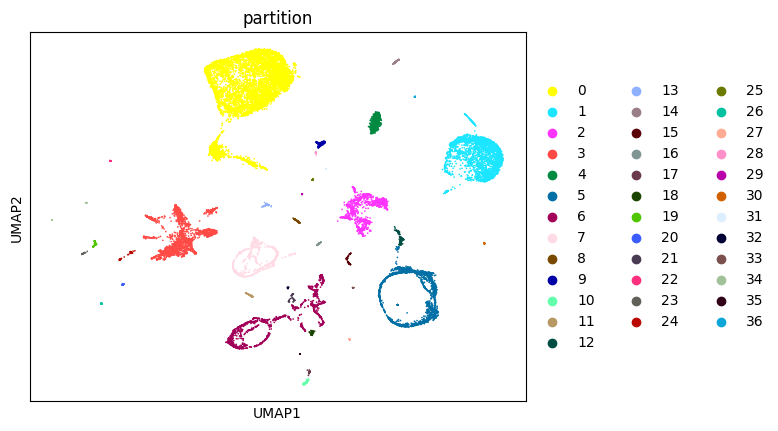

In [3]:
sc.pp.neighbors(adata,use_rep='X_umap')
sc.tl.leiden(adata)
st2.tl.find_disconnected_components(adata,groups='leiden')
sc.pl.umap(adata,color='partition')

With default parameters, we find 34 distinct components in the data. 

Many are small clusters which are not adequate for trajectory inference and can be filtered out

In [4]:
adata.obs['partition'].value_counts().plot.bar()

<AxesSubplot:>

We keep components with more than 500 cells

In [5]:
big_components_idx = np.where(np.bincount(adata.obs['partition'])>500)[0]
adata = adata[np.isin(adata.obs['partition'],big_components_idx.astype(str))]

Now let's find a first guess of the graph

In [6]:
st2.tl.seed_graph(adata,use_partition=True)
st2.pl.graph(adata,key='seed_epg',color=['partition'])

Seeding initial graph for each partition...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_elpigraph.py:519: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["seed_epg"] = {}


Now we refine the initial guess by learning the principal graph. 

Partitions initialized with higher n_clusters than n_nodes will automatically adjust n_nodes higher to n_nodes = n_clusters+1 

In [7]:
st2.tl.learn_graph(adata,n_nodes=30,use_partition=True)
st2.pl.graph(adata,key='epg',color=['partition'])

Learning elastic principal graph for each partition...


In practice we will likely need to further adjust graph learning parameters for different partitions

Here e.g., we decide to tune graph parameters for red, grey, pink and brown partitions

We simply need to change the use_partition parameter to a list

In [8]:
st2.pl.graph(adata,key='seed_epg',color=['partition'])

In [9]:
use_partition=['3','5','6','7']
st2.tl.seed_graph(adata,n_clusters=50,use_partition=use_partition)
st2.tl.learn_graph(adata,n_nodes=60,epg_alpha=0.01,epg_mu=0.05,use_partition=use_partition)
st2.pl.graph(adata,key='seed_epg',color=['partition'])
st2.pl.graph(adata,key='epg',color=['partition'])

Seeding initial graph for each partition...
Learning elastic principal graph for each partition...


Finally we can use heuristics to choose plausible loops / missing paths to add to the graph.

Suggested paths will likely need to be sanity checked rather than immediately added to the graph (as we do here with inplace=True)

In [10]:
adata2=adata.copy()
st2.tl.find_paths(adata2, 
                  inplace=True, 
                  max_inner_fraction=.15,
                  use_partition=True,verbose=1)
st2.pl.graph(adata2,key='epg',color=['partition'],fig_size=(15,10))

Searching potential loops for each partition...
Using default parameters: max_n_points=343, radius=1.76, min_node_n_points=8, min_path_len=6, nnodes=6
testing 2 candidates
Found no valid path to add
Using default parameters: max_n_points=137, radius=1.43, min_node_n_points=1, min_path_len=12, nnodes=6
testing 0 candidates
Found no valid path to add
Using default parameters: max_n_points=145, radius=1.18, min_node_n_points=1, min_path_len=6, nnodes=6
testing 0 candidates
Found no valid path to add
Using default parameters: max_n_points=34, radius=0.27, min_node_n_points=10, min_path_len=6, nnodes=6
testing 1 candidates
Found no valid path to add
Using default parameters: max_n_points=42, radius=1.03, min_node_n_points=1, min_path_len=12, nnodes=6
testing 14 candidates
Suggested paths:
  source node  target node  inner fraction     MSE  n° of points in path
           40           30          0.1047  0.0102                   622
Using default parameters: max_n_points=70, radius=0.66, min

In [11]:
st2.pl.graph(adata2,key='epg',color=['partition'],fig_size=(15,10),
            save_fig=True,fig_path='../manuscript_notebooks/figures/complex/',fig_name='complex_structure.pdf')

We can extract and analyze the pink partition separately and notice it is missing some paths we want to explore.

We can fine-tune this using add_path (and del_path)

In [12]:
sadata = st2.tl.get_component(adata,'6')
st2.tl._elpigraph._store_graph_attributes(sadata,sadata.obsm['X_umap'],'epg')
st2.pl.graph(sadata,key='epg',color=['partition'],show_text=True)

st2.tl.add_path(sadata,source=21,target=12)
st2.pl.graph(sadata,key='epg',color=['partition'],show_text=True)

st2.tl.add_path(sadata,source=39,target=51,epg_mu=1)
st2.pl.graph(sadata,key='epg',color=['partition'],show_text=True)